- load logs
- normalisation
- feture engineering 
- UMAP

In [59]:
from welly import Project
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [63]:
data_df = pd.read_csv("./LASDF_ss.csv").drop(['UWI'], axis=1)
# data_df = pd.read_csv("./big_df.csv")

In [64]:
data_df['W'] = data_df['W'].apply(lambda n: n[:-4])
data_df['LITHOLOGY_GEOLINK'] = data_df.apply(lambda row: row['LITHOLOGY_GEOLINK'] if not np.isnan(row['LITHOLOGY_GEOLINK']) else -1, axis=1)

In [65]:
data_df.head()

,Unnamed: 0,LITHOLOGY_GEOLINK,W,CALI,DRHO,NPHI,RHOB,GR,DTC,RDEP,SP,RSHA,RMED,MD
0,0,-1.0,15_9-12,19.406000,-0.708,NaN,1.789,64.497482,167.582153,1.574993,0.694700,1.546029,1.546029,493.493134
1,1,-1.0,15_9-12,19.406000,-0.722,NaN,1.754,62.406261,167.425064,1.569011,0.445339,1.570030,1.570030,493.645538
2,2,-1.0,15_9-12,19.406000,-0.620,NaN,1.778,62.629055,167.808395,1.578010,0.727901,1.594994,1.594994,493.797943
3,3,-1.0,15_9-12,19.452999,-0.648,NaN,1.642,65.998596,169.244873,1.586024,1.474898,1.589930,1.589930,493.950348
4,4,-1.0,15_9-12,19.452999,-0.685,NaN,1.563,64.997223,170.635086,1.603011,-0.023000,1.540016,1.540016,494.102722


In [66]:
valid_df = data_df.loc[~data_df.isna().any(axis=1)]

In [67]:
valid_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1138051 entries, 3954 to 3134955
Data columns (total 14 columns):
Unnamed: 0           1138051 non-null int64
LITHOLOGY_GEOLINK    1138051 non-null float64
W                    1138051 non-null object
CALI                 1138051 non-null float64
DRHO                 1138051 non-null float64
NPHI                 1138051 non-null float64
RHOB                 1138051 non-null float64
GR                   1138051 non-null float64
DTC                  1138051 non-null float64
RDEP                 1138051 non-null float64
SP                   1138051 non-null float64
RSHA                 1138051 non-null float64
RMED                 1138051 non-null float64
MD                   1138051 non-null float64
dtypes: float64(12), int64(1), object(1)
memory usage: 130.2+ MB


#### Features

In [68]:
meta_df = valid_df['W'].copy()
valid_df= valid_df.drop(['W','Unnamed: 0'], axis=1)

In [69]:
dfs = [meta_df, valid_df]
windows = [10*6]
for w in windows:
    win_df = valid_df.rolling(w, win_type='blackmanharris').sum().rename(lambda n: n+"_meanT{}".format(w), axis='columns')
    dfs.append(win_df)
    
    win_df = valid_df.rolling(w, win_type='blackmanharris').sum().shift(-w+1).rename(lambda n: n+"_meanL{}".format(w), axis='columns')
    dfs.append(win_df)
    
for w in windows:
    win_df = valid_df.rolling(w, center=True).var().rename(lambda n: n+"_var{}".format(w), axis='columns')
    dfs.append(win_df)

feature_df = pd.concat(dfs, axis='columns')
feature_df.columns.values

array(['W', 'LITHOLOGY_GEOLINK', 'CALI', 'DRHO', 'NPHI', 'RHOB', 'GR',
       'DTC', 'RDEP', 'SP', 'RSHA', 'RMED', 'MD',
       'LITHOLOGY_GEOLINK_meanT60', 'CALI_meanT60', 'DRHO_meanT60',
       'NPHI_meanT60', 'RHOB_meanT60', 'GR_meanT60', 'DTC_meanT60',
       'RDEP_meanT60', 'SP_meanT60', 'RSHA_meanT60', 'RMED_meanT60',
       'MD_meanT60', 'LITHOLOGY_GEOLINK_meanL60', 'CALI_meanL60',
       'DRHO_meanL60', 'NPHI_meanL60', 'RHOB_meanL60', 'GR_meanL60',
       'DTC_meanL60', 'RDEP_meanL60', 'SP_meanL60', 'RSHA_meanL60',
       'RMED_meanL60', 'MD_meanL60', 'LITHOLOGY_GEOLINK_var60',
       'CALI_var60', 'DRHO_var60', 'NPHI_var60', 'RHOB_var60', 'GR_var60',
       'DTC_var60', 'RDEP_var60', 'SP_var60', 'RSHA_var60', 'RMED_var60',
       'MD_var60'], dtype=object)

In [70]:
feature_df = feature_df.dropna()

In [71]:
# take a smaller random sample
feature_df = feature_df.sample(50000)

In [72]:
X = feature_df.drop(['W'], axis=1).values.tolist()
print(len(X), len(X[0]))

50000 48


#### Scaling

UMAP Expects normally distributed data

In [78]:
from sklearn.preprocessing import RobustScaler

In [79]:
scaler = RobustScaler()
scaler.fit(X)

RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
             with_scaling=True)

In [80]:
Xs = scaler.transform(X)

#### Run UMAP

In [81]:
n_neighbors=50 # default 15
min_dist=0.9 # defult 0.1
n_components=2
metric='euclidean'

In [82]:
import umap
reducer = umap.UMAP(
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        n_components=n_components,
        metric=metric)

In [83]:
embedding = reducer.fit_transform(Xs)
embedding.shape

//anaconda3/lib/python3.7/site-packages/numba/compiler.py:588: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../../anaconda3/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  self.func_ir.loc))
//anaconda3/lib/python3.7/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 2 separate connected components using meta-embedding (experimental)
  n_components


(50000, 2)

In [84]:
import matplotlib.pyplot as plt

In [87]:
NUM_LITH = 37

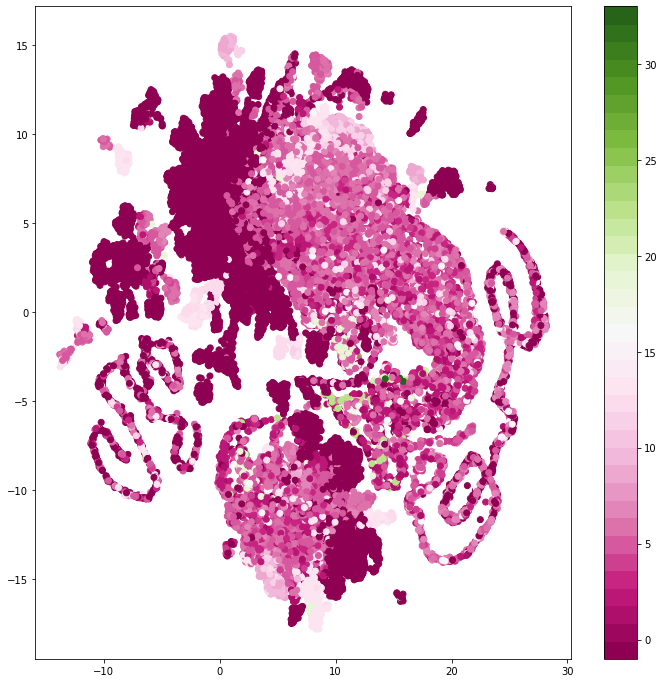

In [88]:
import matplotlib as mpl
cmap = mpl.cm.get_cmap('PiYG', NUM_LITH)
plt.figure(figsize=(12,12))
plt.scatter(embedding[:,0], embedding[:,1], c=feature_df['LITHOLOGY_GEOLINK'], cmap=cmap)
plt.colorbar()